In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import dynamic_feature_last_position_taken

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationary_dgp, 
    make_ohlc,
    FeatureEngineering
)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

In this notebook we consider two cointegrated price series $X_t = X_{t-1} + e_t; e_t \sim N(0, \sigma^2)$ is a random walk; and $Y_t = X_t + \epsilon_t$ where $\epsilon_t$ is a stationary mean reverting signal generated by Ornstein–Uhlenbeck process, it is basically an autoregressive noise. 

$X_t$ and $Y_t$ are both non-stationary and integrated of order 1 - I(1).

But the resultant portfolio $Y - X = \epsilon_t$ is a stationary process - I(0) and is mean reverting

In [2]:
x0, mu_epsilon = 100, 200

N, window, stride = 100000, 24, 24  # simulation with ohlc
# N, window, stride = 10000, 1, 1  # simulation with tick data

train_set_random_state = 42
x_c, y_c = stationary_dgp(N=N, x0=x0, mu=mu_epsilon, random_state=train_set_random_state)
y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
# spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

In [3]:
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
    row_heights=[0.33, 0.33, 0.34],
    subplot_titles=["Candlestick Chart: X", "Candlestick Chart: Y", "Candlestick Chart: Y - X"]
)

# Row 1: X candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=x_o,
    high=x_h,
    low=x_l,
    close=x_c,
    name="X"
), row=1, col=1)

# Row 2: Y candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=y_o,
    high=y_h,
    low=y_l,
    close=y_c,
    name="Y"
), row=2, col=1)

# Row 3: Y - X candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=spread_o,
    high=spread_h,
    low=spread_l,
    close=spread_c,
    name="Y - X"
), row=3, col=1)

# Layout adjustments
fig.update_layout(
    height=600,
    xaxis_rangeslider_visible=False,   # Row 1
    xaxis2_rangeslider_visible=False,  # Row 2
    xaxis3_rangeslider_visible=False,  # Row 3
    showlegend=False,
    margin=dict(t=40, b=20)
)

fig.show()

In [4]:
# confirm the x, y pair is cointegrated, such that spread is stationary
x_ols = sm.add_constant(x_c)
ols = sm.OLS(y_c, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.197e+06
Date:                Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                        21:58:29   Log-Likelihood:                 187.05
No. Observations:                4166   AIC:                            -370.1
Df Residuals:                    4164   BIC:                            -357.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        199.9724      0.042   4715.075      0.0

In [5]:
adfuller_test = adfuller(spread_c)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -59.2862851067775
p-value: 0.0
Is the spread stationary? Yes


In [6]:
feature_config = [
    {'type': 'rolling_mean_corrected',
     'params': {
       'cols': ['close'],
       'window': 100,
     }},
]

df_train = df.copy()
fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)
df_train

,open,high,low,close,feature_close_rolling_mean_corrected
2020-01-01,199.986174,200.549237,199.319746,199.802509,0.000000
2020-01-02,199.645954,200.435982,199.612046,199.948100,0.072796
2020-01-03,199.979395,200.403368,199.656875,200.142213,0.177939
2020-01-04,200.206174,200.651949,199.902046,200.274014,0.232305
2020-01-05,200.122038,200.695065,199.800625,200.171634,0.103940
...,...,...,...,...,...
2031-05-24,200.289505,200.562267,199.683165,200.403368,0.406366
2031-05-25,200.328411,200.867773,199.559922,200.168429,0.166812
2031-05-26,200.196776,200.803471,199.726151,200.041121,0.039671
2031-05-27,200.228767,200.609699,199.439465,199.930831,-0.070199


In [7]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        # dynamic_feature_functions = [],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1. -1.]
Market Return :  0.11%   |   Portfolio Return : -24.18%   |   Position Changes : 2851   |   Episode Length : 4166   |   


In [8]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions, target_net_layers=[8], policy_net_layers=[8])
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return :  0.11%   |   Portfolio Return : -50.86%   |   Position Changes : 2531   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : -26.16%   |   Position Changes : 3249   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 79.73%   |   Position Changes : 3228   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 644.42%   |   Position Changes : 1991   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 800.35%   |   Position Changes : 1734   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1163.32%   |   Position Changes : 1581   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1211.39%   |   Position Changes : 1514   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1097.21%   |   Position Changes : 1444   |   Episode Length : 4166   |   
Market Return :  0.11%   |   P

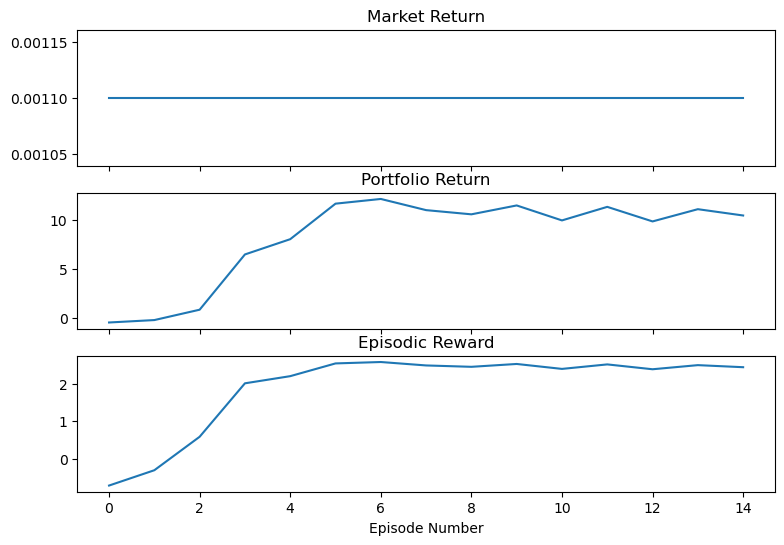

In [9]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

fig, axs = plt.subplots(3, 1, figsize=(9, 6), sharex=True)
axs[0].plot(all_metrics["Market Return"], label="Market Return")
axs[0].set_title("Market Return")
axs[1].plot(all_metrics["Portfolio Return"], label="Portfolio Return")
axs[1].set_title("Portfolio Return")
axs[2].plot(all_metrics["episodic_reward"], label="Episodic Reward")
axs[2].set_title("Episodic Reward")
axs[2].set_xlabel("Episode Number")
plt.show()

In [10]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
history_dfs = []
for i in range(10):
    x_c, y_c = stationary_dgp(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationary_dgp_qlearning",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            # dynamic_feature_functions = [],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))
    history_dfs.append(pd.DataFrame(list(env_test.unwrapped.historical_info)))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.22%   |   Portfolio Return : 464.10%   |   Position Changes : 2771   |   Episode Length : 4166   |   
Market Return : -0.02%   |   Portfolio Return : 430.41%   |   Position Changes : 2743   |   Episode Length : 4166   |   
Market Return :  0.39%   |   Portfolio Return : 425.42%   |   Position Changes : 2736   |   Episode Length : 4166   |   
Market Return : -0.10%   |   Portfolio Return : 432.80%   |   Position Changes : 2772   |   Episode Length : 4166   |   
Market Return :  0.13%   |   Portfolio Return : 446.43%   |   Position Changes : 2787   |   Episode Length : 4166   |   
Market Return : -0.06%   |   Portfolio Return : 332.89%   |   Position Changes : 2779   |   Episode Length : 4166   |   
Market Return :  0.01%   |   Portfolio Return : 558.79%   |   Position Changes : 2775   |   Episode Length : 4166   |   
Market Return : -0.02%   |   Portfolio Return : 476.19%   |   Position Changes : 2746   |   Episode Length : 4166   |   
Market Return : -0.24%   |   Por

In [11]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

historical_info_df = history_dfs[-2]
historical_info_df.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_open', 'data_low', 'data_high', 'data_volume', 'data_close',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

In [12]:
def extract_signals(historical_info_df: pd.DataFrame):
    """
    Given a DataFrame with columns ['data_close', 'position'], 
    shift and detect only the entry/exit transitions.
    Returns (buy_df, sell_df, exit_df).
    """
    df = historical_info_df[['data_close', 'position']].copy()
    df['position'] = df['position'].shift(-1)
    df['prev_position'] = df['position'].shift(1)

    buy_df = df[(df['position'] == 1) & (df['prev_position'] != 1)]
    sell_df = df[(df['position'] == -1) & (df['prev_position'] != -1)]
    exit_df = df[(df['position'] == 0) & (df['prev_position'] != 0)]

    return buy_df, sell_df, exit_df


def build_fig(historical_info_df: pd.DataFrame,
              buy_df: pd.DataFrame,
              sell_df: pd.DataFrame,
              exit_df: pd.DataFrame):
    """
    Build a 2-row subplot:
     - Row 1: candlestick + buy/sell/exit markers
     - Row 2: portfolio valuation line
    Returns the Plotly Figure.
    """
    sample = historical_info_df
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        row_heights=[0.7, 0.3],
        subplot_titles=["Price Candlestick", "Portfolio Value"]
    )

    # Row 1: Candlestick
    fig.add_trace(go.Candlestick(
        x=sample.index,
        open=sample['data_open'],
        high=sample['data_high'],
        low=sample['data_low'],
        close=sample['data_close'],
        name="Price"
    ), row=1, col=1)

    # Markers
    marker_specs = {
        'Buy':    dict(df=buy_df,   color='green', symbol='triangle-up'),
        'Sell':   dict(df=sell_df,  color='red',   symbol='triangle-down'),
        'Exit':   dict(df=exit_df,  color='blue',  symbol='circle'),
    }
    for name, spec in marker_specs.items():
        fig.add_trace(go.Scatter(
            x=spec['df'].index,
            y=spec['df']['data_close'],
            mode='markers',
            marker=dict(color=spec['color'], size=10, symbol=spec['symbol']),
            name=name
        ), row=1, col=1)

    # Row 2: Portfolio value
    fig.add_trace(go.Scatter(
        x=sample.index,
        y=sample['portfolio_valuation'],
        mode='lines',
        line=dict(color='blue'),
        name="Portfolio Value"
    ), row=2, col=1)

    # Layout
    fig.update_layout(
        height=500,
        margin=dict(t=40, b=20, l=40, r=20),
        xaxis_rangeslider_visible=False,
        xaxis2_rangeslider_visible=False  # if you ever disable or have more subplots
    )
    return fig

In [13]:
buy_df_qlearning, sell_df_qlearning, exit_df_qlearning = extract_signals(historical_info_df)
fig_qlearning = build_fig(
    historical_info_df,
    buy_df_qlearning,
    sell_df_qlearning,
    exit_df_qlearning
)
fig_qlearning.show()

In [14]:
historical_info_df

,idx,step,date,position_index,position,real_position,data_open,data_low,data_high,data_volume,data_close,portfolio_valuation,portfolio_distribution_asset,portfolio_distribution_fiat,portfolio_distribution_borrowed_asset,portfolio_distribution_borrowed_fiat,portfolio_distribution_interest_asset,portfolio_distribution_interest_fiat,reward
0,0,0,2020-01-01,0,-1,-1.000000,199.895160,199.694166,200.705084,0.0,200.051498,1000.000000,0.000000,2.000000e+03,4.998713,0,0.000000,0.0,0.000000
1,1,1,2020-01-02,2,1,1.000000,200.015326,199.395272,200.431125,0.0,200.168244,1000.383460,4.997713,2.273737e-13,0.000000,0,0.000000,0.0,0.000383
2,2,2,2020-01-03,0,-1,-0.996577,200.043299,199.622241,200.547551,0.0,199.824478,1001.898107,0.000000,2.000367e+03,4.996714,0,0.000015,0.0,0.001513
3,3,3,2020-01-04,2,1,0.999997,199.764898,199.469542,200.585608,0.0,200.004125,1002.601616,5.012890,2.995397e-03,0.000000,0,0.000000,0.0,0.000702
4,4,4,2020-01-05,0,-1,-1.000859,199.684448,199.085404,200.610159,0.0,200.089396,1001.970735,0.000000,2.004802e+03,5.011902,0,0.000015,0.0,-0.000629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,4161,4161,2031-05-24,0,-1,-1.001508,200.040874,199.407147,200.459618,0.0,200.083022,7090.571354,0.000000,1.419184e+04,35.491485,0,0.000106,0.0,-0.000954
4162,4162,4162,2031-05-25,0,-1,-0.998047,200.062315,199.594205,200.401808,0.0,199.736973,7102.853198,0.000000,1.419184e+04,35.491485,0,0.000106,0.0,0.001731
4163,4163,4163,2031-05-26,2,1,0.999997,199.815210,199.467651,200.170497,0.0,199.904195,7107.400696,35.553928,2.126689e-02,0.000000,0,0.000000,0.0,0.000640
4164,4164,4164,2031-05-27,0,-1,-0.996881,199.914663,199.437363,200.118029,0.0,199.591340,7117.079134,0.000000,1.421196e+04,35.546925,0,0.000107,0.0,0.001361


In [15]:
def plot_signals_distribution(signals_df, threshold):
    """
    Plots a violin + jittered stripplot of data_close by position,
    with a horizontal line at `threshold`.
    """
    plt.figure(figsize=(8, 6))
    # Violin (no inner box)
    sns.violinplot(
        data=signals_df,
        x='position',
        y='data_close',
        inner=None,
        color=".8"
    )
    # Jittered points
    sns.stripplot(
        data=signals_df,
        x='position',
        y='data_close',
        jitter=0.2,
        size=4,
        alpha=0.6
    )
    # Threshold line
    plt.axhline(threshold, color='r', linestyle='--', label=f'y = {threshold}')
    plt.legend()

    plt.title('Distribution + Jittered Points by Position')
    plt.tight_layout()
    plt.show()


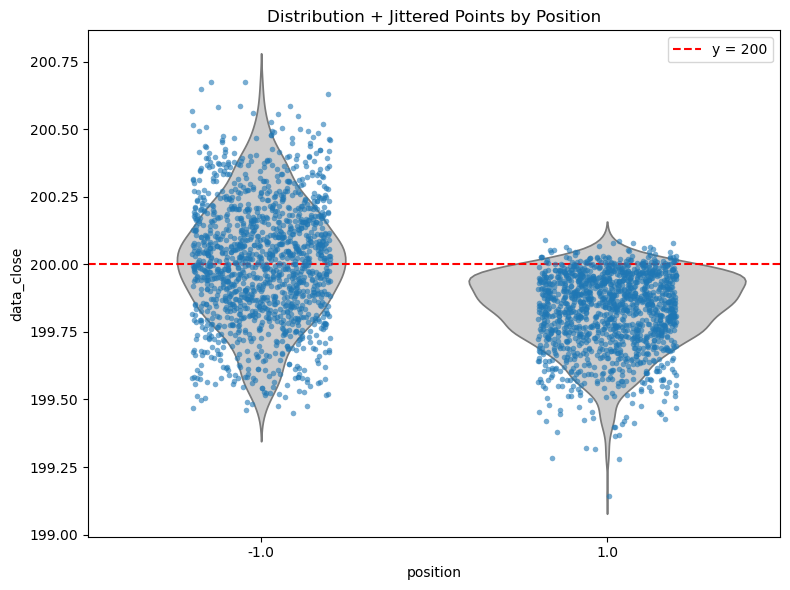

In [16]:
signals_df_qlearning = pd.concat([buy_df_qlearning, sell_df_qlearning, exit_df_qlearning])
plot_signals_distribution(signals_df_qlearning, threshold=mu_epsilon)

In [17]:
# build features
df_train = df.copy()

feature_config = [
    # {'type': 'rolling',
    #  'params': {
    #    'cols': ['close'],
    #    'window': 7,
    #    'mode': 'diff',
    #    'subtract_mean': False
    #  }},
    {'type': 'select',
     'params': {
         'cols': ['close'],
     }}
]

fe = FeatureEngineering(df_train)
fe.build_features(feature_config)
df_train = fe.df.copy()
df_train

,open,high,low,close,feature_close
2020-01-01,199.986174,200.549237,199.319746,199.802509,199.802509
2020-01-02,199.645954,200.435982,199.612046,199.948100,199.948100
2020-01-03,199.979395,200.403368,199.656875,200.142213,200.142213
2020-01-04,200.206174,200.651949,199.902046,200.274014,200.274014
2020-01-05,200.122038,200.695065,199.800625,200.171634,200.171634
...,...,...,...,...,...
2031-05-24,200.289505,200.562267,199.683165,200.403368,200.403368
2031-05-25,200.328411,200.867773,199.559922,200.168429,200.168429
2031-05-26,200.196776,200.803471,199.726151,200.041121,200.041121
2031-05-27,200.228767,200.609699,199.439465,199.930831,199.930831


In [18]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[199.8025   0.       0.    ]
Market Return :  0.11%   |   Portfolio Return : -0.12%   |   Position Changes : 1   |   Episode Length : 4166   |   


In [19]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return :  0.11%   |   Portfolio Return : -27.77%   |   Position Changes : 2775   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : -32.08%   |   Position Changes : 2755   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 204.85%   |   Position Changes : 2624   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 209.22%   |   Position Changes : 2702   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 625.39%   |   Position Changes : 2557   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 580.93%   |   Position Changes : 2546   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1024.12%   |   Position Changes : 2468   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 974.12%   |   Position Changes : 2477   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Po

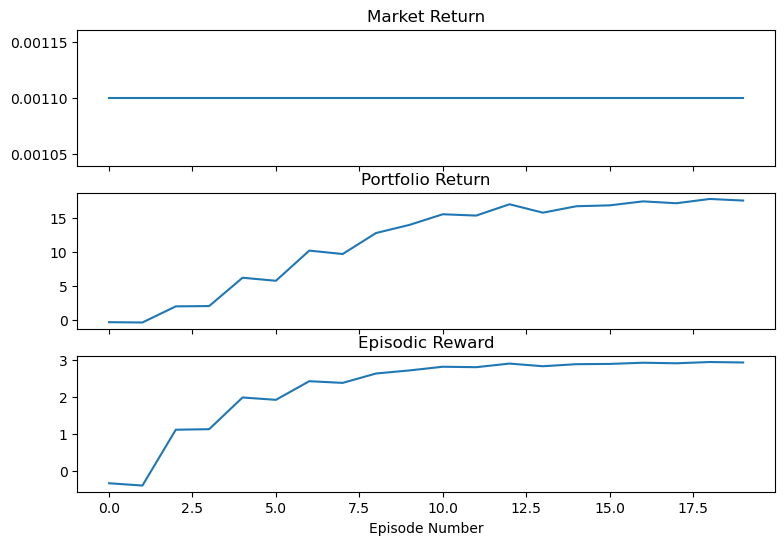

In [20]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

fig, axs = plt.subplots(3, 1, figsize=(9, 6), sharex=True)
axs[0].plot(all_metrics["Market Return"], label="Market Return")
axs[0].set_title("Market Return")
axs[1].plot(all_metrics["Portfolio Return"], label="Portfolio Return")
axs[1].set_title("Portfolio Return")
axs[2].plot(all_metrics["episodic_reward"], label="Episodic Reward")
axs[2].set_title("Episodic Reward")
axs[2].set_xlabel("Episode Number")
plt.show()

In [21]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
history_dfs = []
for i in range(10):
    x_c, y_c = stationary_dgp(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    fe = FeatureEngineering(_df)
    fe.build_features(feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationary_dgp_xgboost",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))
    history_dfs.append(pd.DataFrame(list(env_test.unwrapped.historical_info)))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.22%   |   Portfolio Return : 1729.79%   |   Position Changes : 2440   |   Episode Length : 4166   |   
Market Return : -0.02%   |   Portfolio Return : 1621.94%   |   Position Changes : 2289   |   Episode Length : 4166   |   
Market Return :  0.39%   |   Portfolio Return : 1601.74%   |   Position Changes : 2353   |   Episode Length : 4166   |   
Market Return : -0.10%   |   Portfolio Return : 1621.90%   |   Position Changes : 2395   |   Episode Length : 4166   |   
Market Return :  0.13%   |   Portfolio Return : 1654.71%   |   Position Changes : 2422   |   Episode Length : 4166   |   
Market Return : -0.06%   |   Portfolio Return : 1593.09%   |   Position Changes : 2390   |   Episode Length : 4166   |   
Market Return :  0.01%   |   Portfolio Return : 1931.88%   |   Position Changes : 2363   |   Episode Length : 4166   |   
Market Return : -0.02%   |   Portfolio Return : 1595.30%   |   Position Changes : 2347   |   Episode Length : 4166   |   
Market Return : -0.24%  

In [22]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

In [23]:
historical_info_df = history_dfs[-1]
buy_df_xgb, sell_df_xgb, exit_df_xgb = extract_signals(historical_info_df)
fig_xgb = build_fig(
    historical_info_df,
    buy_df_xgb,
    sell_df_xgb,
    exit_df_xgb
)
fig_xgb.show()

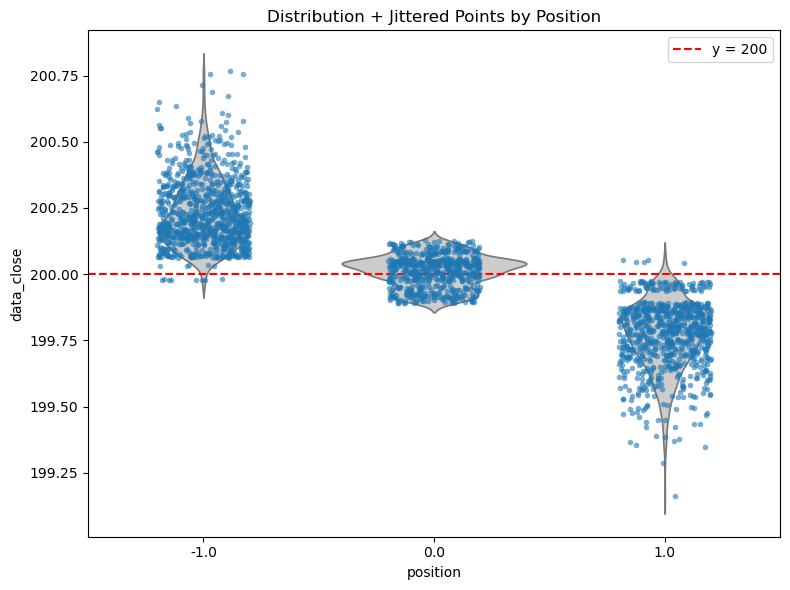

In [24]:
signals_df_xgb = pd.concat([buy_df_xgb, sell_df_xgb, exit_df_xgb])
plot_signals_distribution(signals_df_xgb, threshold=mu_epsilon)

In [25]:
len(signals_df_qlearning), len(signals_df_xgb)

(2773, 2343)

In [26]:
signals_df_qlearning["above"] = signals_df_qlearning["data_close"] > mu_epsilon
signals_df_qlearning.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: f'≤ {mu_epsilon}', True: f'> {mu_epsilon}'})

above,≤ 200,> 200
position,,
-1.0,682,704
1.0,1295,92


In [27]:
signals_df_xgb["above"] = signals_df_xgb["data_close"] > mu_epsilon
signals_df_xgb.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: f'≤ {mu_epsilon}', True: f'> {mu_epsilon}'})

above,≤ 200,> 200
position,,
-1.0,8,925
0.0,243,384
1.0,778,5
